In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
pip install razdel

Note: you may need to restart the kernel to use updated packages.


In [31]:
from razdel import tokenize

In [4]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_length):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]  
        label = self.labels[idx]

        # Токенизация с помощью razdel
        tokens = [token.text for token in tokenize(text)][:self.max_length]
        sequence = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]

        # Паддинг
        if len(sequence) < self.max_length:
            sequence += [self.word2idx['<PAD>']] * (self.max_length - len(sequence))
        else: 
            sequence = sequence[:self.max_length]

        return torch.tensor(sequence), torch.tensor(label)

def preprocess_text(text):
    # Проверяем что текст не None и строка
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # Удаляю все символы кроме букв и пробелов
    text = re.sub(r'[^a-zA-Zа-яА-Я\s]', '', text)
    # Удаляю лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_preprocess_data(file_path, sample_size=60000):
    df = pd.read_csv(file_path, encoding='utf-8', sep=',')
    cols=['id']
    df = df.drop(columns=cols)
    
    print(f"Размер данных: {df.shape}")
    print(f"Колонки: {df.columns.tolist()}")
    print(f"\nПримеры данных:")
    print(df[['public_petition_text', 'reason_category']].sample(3))
    
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
        print(f"Взята выборка: {len(df)} строк")
    
    # Проверяем наличие NaN значений
    print(f"\nПроверка данных:")
    print(f"Пустые тексты: {df['public_petition_text'].isna().sum()}")
    print(f"Пустые категории: {df['reason_category'].isna().sum()}")
    
    # Удаляем пустые значения
    df = df.dropna(subset=['public_petition_text', 'reason_category'])
    print(f"Данные после очистки: {len(df)} строк")
    
    df['text_clean'] = df['public_petition_text'].apply(preprocess_text)
    
    print(f"\nАнализ категорий:")
    category_counts = df['reason_category'].value_counts()
    print(category_counts)
    print(f"Всего категорий: {len(category_counts)}")
    
    return df

df = load_and_preprocess_data('C:/Users/Zver/Desktop/machine_learning/data/Petitions.csv')

Размер данных: (59889, 2)
Колонки: ['public_petition_text', 'reason_category']

Примеры данных:
                                    public_petition_text  reason_category
39201                  Спортивный комплекс весь изрисан.  Благоустройство
20181  Не выполняется ежедневная очистка урн около вс...  Благоустройство
35736  Вандальные надписи на электробудке по адресу у...  Благоустройство

Проверка данных:
Пустые тексты: 0
Пустые категории: 0
Данные после очистки: 59889 строк

Анализ категорий:
reason_category
Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элем

In [11]:
def balance_dataset(df, undersample_threshold=900, oversample_threshold=400, target_size=600):
    
    category_counts = df['reason_category'].value_counts()
    print("Исходное распределение:")
    
    balanced_dfs = []
    
    for category in df['reason_category'].unique():
        category_df = df[df['reason_category'] == category]
        original_count = len(category_df)
        
        if original_count >= undersample_threshold:
            # Большие классы - undersampling
            balanced_category = category_df.sample(undersample_threshold, random_state=42)
            print(f"   {category}: {original_count} → {undersample_threshold} (undersampled)")
            
        elif original_count >= oversample_threshold:
            # Средние классы - оставляем как есть
            balanced_category = category_df
            print(f"   {category}: {original_count} (оставлен)")
            
        else:
            # Маленькие классы - oversampling до target_size = 600
            if original_count > 0:
                balanced_category = category_df.sample(target_size, replace=True, random_state=42)
                print(f"   {category}: {original_count} → {target_size} (oversampled)")
            else:
                balanced_category = category_df
                print(f"   {category}: {original_count} (очень маленький, оставлен)")
        
        balanced_dfs.append(balanced_category)
    
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    print(f"\nИтоговое распределение:")
    final_counts = balanced_df['reason_category'].value_counts()
    for category, count in final_counts.items():
        print(f"   {category}: {count} примеров")
    
    print(f"Всего примеров: {len(balanced_df)}")
    print(f"Сохранено категорий: {len(final_counts)}")
    
    return balanced_df

# Применяем балансировку
df_balanced = balance_dataset(df, undersample_threshold=800, oversample_threshold=400, target_size=600)

def build_vocabulary(texts, min_freq=2):
    """Создает словарь для векторизации токенов"""
    
    # Собираем все слова с помощью razdel
    all_words = []
    for text in texts:
        # Токенизируем каждый текст с помощью razdel
        tokens = [token.text for token in tokenize(text)]
        all_words.extend(tokens)
    
    # Считаем частоты
    word_freq = Counter(all_words)
    
    # Создаем словарь
    vocabulary = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocabulary[word] = idx
            idx += 1
    
    print(f"\nВсего уникальных слов: {len(word_freq)}")
    print(f"Слов в словаре: {len(vocabulary)}")
    
    return vocabulary

def prepare_data(df):
    
    # Создаем словарь
    vocab = build_vocabulary(df['text_clean'].tolist(), min_freq=2)
    
    # Кодируем целевой признак
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(df['reason_category'])
    
    for i, class_name in enumerate(label_encoder.classes_):
        class_count = (labels_encoded == i).sum()
        print(f"   '{class_name}' -> {i} ({class_count} примеров)")
    
    # Разделяем данные
    X_train, X_test, y_train, y_test = train_test_split(
        df['text_clean'].tolist(), 
        labels_encoded.tolist(), 
        test_size=0.2, 
        random_state=42,
        stratify=labels_encoded
    )
    
    print(f"\nОбучающая выборка: {len(X_train)} текстов")
    print(f"Тестовая выборка: {len(X_test)} текстов")
    
    return X_train, X_test, y_train, y_test, vocab, label_encoder

X_train, X_test, y_train, y_test, vocab, label_encoder = prepare_data(df_balanced)

# Создаем DataLoaders
BATCH_SIZE = 128
MAX_LENGTH = 50
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_encoder.classes_)

train_dataset = TextDataset(X_train, y_train, vocab, MAX_LENGTH)
test_dataset = TextDataset(X_test, y_test, vocab, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Исходное распределение:
   Благоустройство: 34769 → 800 (undersampled)
   Содержание МКД: 14461 → 800 (undersampled)
   Незаконная информационная и (или) рекламная конструкция: 1831 → 800 (undersampled)
   Фасад: 1483 → 800 (undersampled)
   Водоснабжение: 809 → 800 (undersampled)
   Нарушение правил пользования общим имуществом: 2170 → 800 (undersampled)
   Повреждения или неисправность элементов уличной инфраструктуры: 1164 → 800 (undersampled)
   Кровля: 825 → 800 (undersampled)
   Состояние рекламных или информационных конструкций: 673 (оставлен)
   Нарушение порядка пользования общим имуществом: 243 → 600 (oversampled)
   Подвалы: 254 → 600 (oversampled)
   Водоотведение: 238 → 600 (oversampled)
   Санитарное состояние: 434 (оставлен)
   Центральное отопление: 284 → 600 (oversampled)
   Незаконная реализация товаров с торгового оборудования (прилавок, ящик, с земли): 251 → 600 (oversampled)

Итоговое распределение:
   Благоустройство: 800 примеров
   Содержание МКД: 800 примеров
 

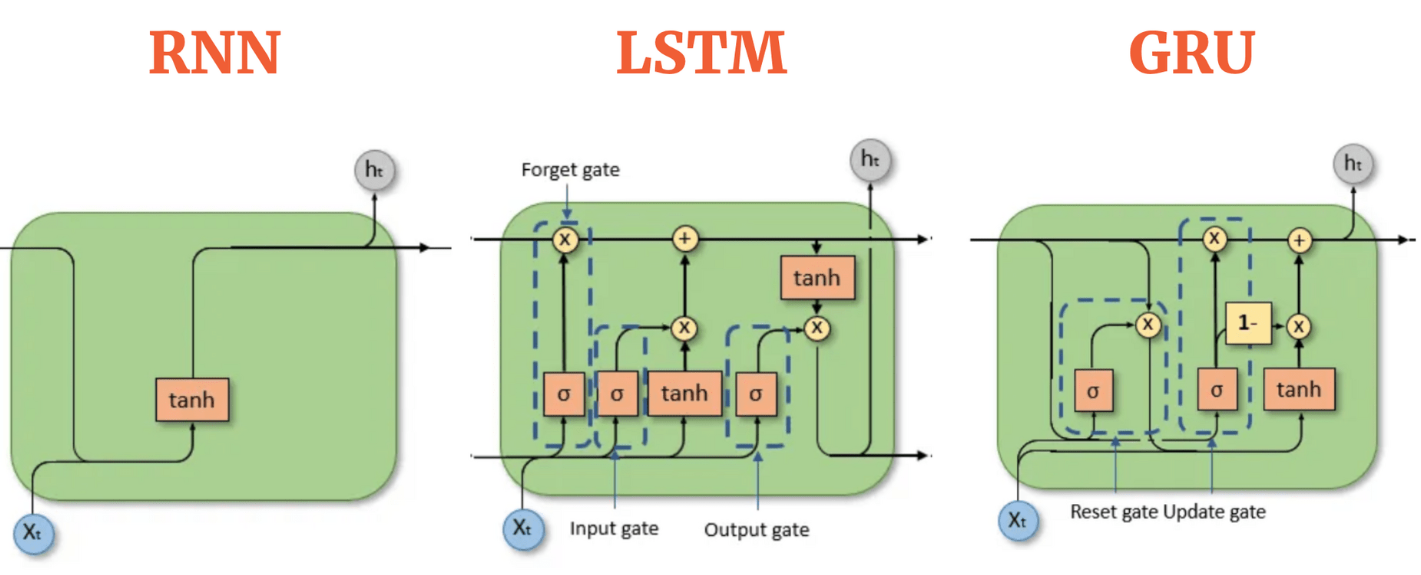

In [29]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
import torch.nn as nn
import torch.optim as optim

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=3, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.batch_norm(hidden)
        hidden = self.dropout(hidden)
        
        return self.fc(hidden)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=3, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.batch_norm(hidden)
        hidden = self.dropout(hidden)
        
        return self.fc(hidden)

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=3, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2) 
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.batch_norm(hidden)
        return self.fc(self.dropout(hidden))

def calculate_class_weights(df):
    """Расчет весов классов"""
    class_counts = df['reason_category'].value_counts().sort_index()
    total_samples = len(df)
    n_classes = len(class_counts)
    
    class_weights = total_samples / (n_classes * class_counts.values)
    
    # Нормализуем веса
    class_weights = class_weights / class_weights.sum() * n_classes
    
    return torch.tensor(class_weights, dtype=torch.float)

def train_model(model, train_loader, criterion, optimizer, device):
    """Обучает модель на одной эпохе"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch_idx, (texts, labels) in enumerate(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        
        _, predicted = torch.max(predictions, 1)
        acc = (predicted == labels).float().mean()
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            predictions = model(texts)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    weighted_f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return epoch_loss / len(test_loader), accuracy, macro_f1, weighted_f1, all_predictions, all_labels

def train_and_evaluate_model(model, model_name, train_loader, test_loader, class_weights, n_epochs=10):
    print(f"\nОбучение: {model_name}")
    print("="*50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используется устройство: {device}")
    model = model.to(device)
    
    # Используем переданные веса
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Обучение
    train_losses = []
    train_accuracies = []
    
    for epoch in range(n_epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        print(f'Epoch {epoch+1:02}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    
    # Оценка
    test_loss, test_accuracy, macro_f1, weighted_f1, predictions, true_labels = evaluate_model(
        model, test_loader, criterion, device
    )
    
    print(f"\nРезультаты {model_name}:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")
    
    # Детальная оценка
    print(f"\nОТЧЕТ:")
    print(classification_report(true_labels, predictions, 
                              target_names=label_encoder.classes_))
    
    return {
        'model': model,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies
    }


# Рассчитываем веса на балансированных данных
class_weights = calculate_class_weights(df_balanced)

models = {
    'RNN': RNNClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'LSTM': LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM), 
    'GRU': GRUClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
}

# Обучаем модели
results = {}
for name, model in models.items():
    results[name] = train_and_evaluate_model(model, name, train_loader, test_loader, class_weights, n_epochs=10)


Обучение: RNN
Используется устройство: cpu
Epoch 01/10, Train Loss: 2.4197, Train Acc: 0.2435
Epoch 02/10, Train Loss: 1.7371, Train Acc: 0.4650
Epoch 03/10, Train Loss: 1.4428, Train Acc: 0.5497
Epoch 04/10, Train Loss: 1.2792, Train Acc: 0.6004
Epoch 05/10, Train Loss: 1.1897, Train Acc: 0.6289
Epoch 06/10, Train Loss: 1.0643, Train Acc: 0.6635
Epoch 07/10, Train Loss: 0.9711, Train Acc: 0.6928
Epoch 08/10, Train Loss: 0.9140, Train Acc: 0.7069
Epoch 09/10, Train Loss: 0.8561, Train Acc: 0.7274
Epoch 10/10, Train Loss: 0.8079, Train Acc: 0.7425

Результаты RNN:
Test Loss: 0.6448
Test Accuracy: 0.7964
Macro F1: 0.8042
Weighted F1: 0.7993

ОТЧЕТ:
                                                                                  precision    recall  f1-score   support

                                                                 Благоустройство       0.50      0.72      0.59       160
                                                                   Водоотведение       0.88      0.

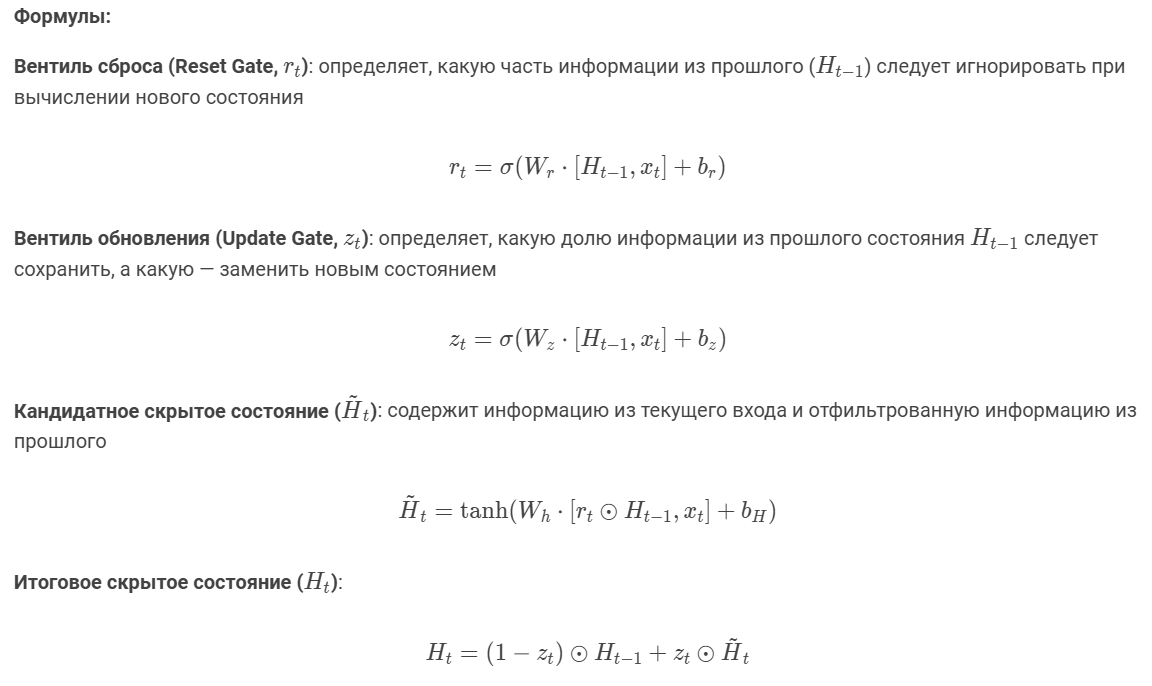

In [23]:
# СОБСТВЕННАЯ РЕАЛИЗАЦИЯ GRU
class CustomGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Веса для вентиля сброса - т.е. выбираем, какую инфу из прошлого состояния забыть
        self.W_ir = nn.Parameter(torch.Tensor(input_size, hidden_size)) # Матрица весов для преобразования входных данных в вентиль сброса
        self.W_hr = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) # Матрица весов для преобразования предыдущего скрытого состояния в вентиль сброса
        self.b_ir = nn.Parameter(torch.Tensor(hidden_size)) # Смещение для входных данных
        self.b_hr = nn.Parameter(torch.Tensor(hidden_size)) # Смещение для скрытого состояния
        
        # Веса для вентиля обновления - аналогично
        self.W_iz = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hz = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_iz = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hz = nn.Parameter(torch.Tensor(hidden_size))
        
        # Веса для кандидата на скрытое состояние
        self.W_in = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hn = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_in = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hn = nn.Parameter(torch.Tensor(hidden_size))
        
        self.reset_parameters()
    
    def reset_parameters(self):
        # Инициализация весов, сначала проверяеем что это матрица, а не вектор
        for weight in self.parameters():
            if weight.dim() > 1:
                nn.init.xavier_uniform_(weight)
            else:
                nn.init.zeros_(weight)
    
    def forward(self, x, h_prev):
        """
        x: текущий вход [batch_size, input_size]
        h_prev: предыдущее скрытое состояние [batch_size, hidden_size]
        """
        # Вентиль сброса
        r_t = torch.sigmoid(
            torch.matmul(x, self.W_ir) + self.b_ir + 
            torch.matmul(h_prev, self.W_hr) + self.b_hr
        )
        
        #Вентиль обновления
        z_t = torch.sigmoid(
            torch.matmul(x, self.W_iz) + self.b_iz + 
            torch.matmul(h_prev, self.W_hz) + self.b_hz
        )
        
        # Кандидатное срытое состояние
        n_t = torch.tanh(
            torch.matmul(x, self.W_in) + self.b_in + 
            r_t * (torch.matmul(h_prev, self.W_hn) + self.b_hn)
        )
        
        # Итоговое скрытое состояние
        h_t = (1 - z_t) * n_t + z_t * h_prev
        
        return h_t

class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=True, dropout=0.0):
        super(CustomGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.dropout = dropout
        
        self.gru_cells = nn.ModuleList([
            CustomGRUCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
        self.dropout_layer = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
    
    def forward(self, x, h_0=None):
        """
        x: входная последовательность [batch_size, seq_len, input_size] если batch_first=True
        h_0: начальное скрытое состояние [num_layers, batch_size, hidden_size]
        """
        if self.batch_first:
            batch_size, seq_len, input_size = x.size()
        else:
            seq_len, batch_size, input_size = x.size()
        
        # Инициализация скрытого состояния
        if h_0 is None:
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        # Транспонируем если нужно
        if not self.batch_first:
            x = x.transpose(0, 1)
        
        # Обработка последовательности
        h_n = []  # скрытые состояния для каждого слоя на последнем временном шаге
        layer_input = x
        
        for layer in range(self.num_layers):
            h_prev = h_0[layer]  # [batch_size, hidden_size]
            h_layer = []
            
            for t in range(seq_len):
                h_prev = self.gru_cells[layer](layer_input[:, t], h_prev)
                h_layer.append(h_prev)
            
            # Сохраняем выход последнего слоя для следующего слоя
            layer_input = torch.stack(h_layer, dim=1)  # [batch_size, seq_len, hidden_size]
            
            # Применяем dropout между слоями (кроме последнего)
            if layer < self.num_layers - 1:
                layer_input = self.dropout_layer(layer_input)
            
            h_n.append(h_prev)
        
        # Возвращаем все выходы и последнее скрытое состояние
        output = layer_input  # [batch_size, seq_len, hidden_size]
        h_n = torch.stack(h_n, dim=0)  # [num_layers, batch_size, hidden_size]
        
        return output, h_n

In [24]:
class CustomGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0) # Слой для преобразования индексов слов в векторы
        self.custom_gru = CustomGRU(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        
        #Выходы и состояния на всех слоях
        output, hidden = self.custom_gru(embedded)
        
        # Используем последнее скрытое состояние
        hidden = self.dropout(hidden[-1])  # Берем dropout к последнему слою
        return self.fc(hidden) # Пропускаем через fc для получения логитов [batch_size, output_dim]

In [27]:
model = {
        'CustomGRU': CustomGRUClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    }

result = {}
for name, model in model.items():
    results[name] = train_and_evaluate_model(model, name, train_loader, test_loader, class_weights, n_epochs=20)


Обучение: CustomGRU
Используется устройство: cpu
Epoch 01/20, Train Loss: 2.5665, Train Acc: 0.1149
Epoch 02/20, Train Loss: 2.1073, Train Acc: 0.2247
Epoch 03/20, Train Loss: 1.6559, Train Acc: 0.3879
Epoch 04/20, Train Loss: 1.2534, Train Acc: 0.5499
Epoch 05/20, Train Loss: 0.8677, Train Acc: 0.7075
Epoch 06/20, Train Loss: 0.6618, Train Acc: 0.7864
Epoch 07/20, Train Loss: 0.5277, Train Acc: 0.8270
Epoch 08/20, Train Loss: 0.4335, Train Acc: 0.8611
Epoch 09/20, Train Loss: 0.3576, Train Acc: 0.8817
Epoch 10/20, Train Loss: 0.3215, Train Acc: 0.8958
Epoch 11/20, Train Loss: 0.2744, Train Acc: 0.9132
Epoch 12/20, Train Loss: 0.2552, Train Acc: 0.9173
Epoch 13/20, Train Loss: 0.2097, Train Acc: 0.9312
Epoch 14/20, Train Loss: 0.1896, Train Acc: 0.9365
Epoch 15/20, Train Loss: 0.1611, Train Acc: 0.9460
Epoch 16/20, Train Loss: 0.1588, Train Acc: 0.9479
Epoch 17/20, Train Loss: 0.1367, Train Acc: 0.9559
Epoch 18/20, Train Loss: 0.1347, Train Acc: 0.9535
Epoch 19/20, Train Loss: 0.1147,